### Logistic Regression (pytorch)

Machine Learning Algorithms 2024

Dates: 2024-3-9

Author: Yung-Kyun Noh

Department of Computer Science, Hanyang University & School of Computational Sciences, KIAS



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device='cuda:0'
# device='cpu'

In [3]:
## Usage example:
# getLogGaussian_torch(data1, torch.tensor(mean1).to('cuda'), torch.tensor(Cov1).to('cuda'))
# getLogGaussian_torch(data1[0].reshape([1,-1]), torch.tensor(mean1).to('cuda'), torch.tensor(Cov1).to('cuda'))
def getLogGaussian_torch(X, mu, Sig):
    ''' evalute log probability of Gaussian distribution
    given the Gaussian distribution model (mean and covariance).'''
    # X: datanum x dim
    nData, nDim = X.shape
    w,v = torch.linalg.eigh(Sig)  # w: eigenvalues
    log_det_Sig = torch.sum(torch.log(w))
    invSig = torch.matmul(torch.matmul(v, torch.diag(1/w)), v.T)
    logPs = torch.zeros(nData)

    const = - nDim / (2.) * torch.log(torch.tensor(2*torch.pi)) \
        - 1 / (2.) * log_det_Sig # sacalar

    X_sub_m = X - mu
    expvals = - 1/2. * torch.sum(torch.matmul(X_sub_m, invSig)*X_sub_m, 1)
    logPs =  const + expvals
    return logPs


### Generate two Gaussian densities

In [4]:
dim = 2
datanum1 = 100
datanum2 = 100
m1 = torch.tensor([-1,0], dtype=torch.float32)
Sig1 = torch.tensor([[2,.5],[.5,2]], dtype=torch.float32)
m2 = torch.tensor([1,0], dtype=torch.float32)
Sig2 = torch.tensor([[1,0],[0,.5]], dtype=torch.float32)

L = torch.linalg.cholesky(Sig1)
data1 = torch.matmul(torch.randn([datanum1,dim], device=device), L.to(device).T) + m1.to(device)
L = torch.linalg.cholesky(Sig2)
data2 = torch.matmul(torch.randn([datanum2,dim], device=device), L.to(device).T) + m2.to(device)

all_data = torch.cat([data1, data2])
ys = torch.cat([1*torch.ones(datanum1), -1*torch.ones(datanum2)]).to(device)


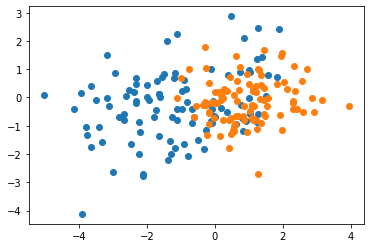

In [5]:
plt.scatter(data1[:,0].to('cpu'), data1[:,1].to('cpu'))
plt.scatter(data2[:,0].to('cpu'), data2[:,1].to('cpu'))
xmin, xmax, ymin, ymax = plt.axis()

### Draw an optimal boundary for two Gaussians

Optimal boundary and the true class-posteriors

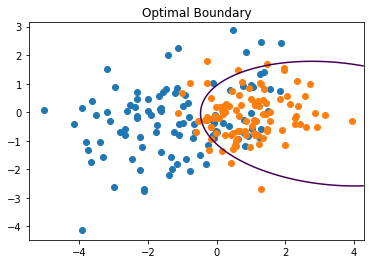

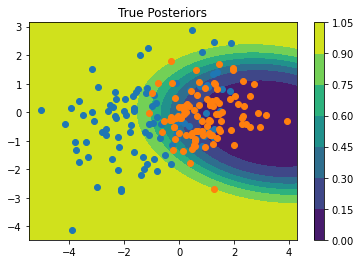

In [6]:
grid_resolution = 100
X = torch.arange(xmin, xmax, (xmax - xmin)/(grid_resolution - 0.01))
Y = torch.arange(ymin, ymax, (ymax - ymin)/(grid_resolution - 0.01))

grid_x, grid_y = torch.meshgrid(X, Y, indexing='ij')
scan_inputs = torch.cat([grid_x.reshape([-1,1]), grid_y.reshape([-1,1])], axis=1)
discri_vals = getLogGaussian_torch(scan_inputs, m1, Sig1) - getLogGaussian_torch(scan_inputs, m2, Sig2)
discri_vals = discri_vals.reshape([grid_resolution,grid_resolution]).T
plt.contour(X, Y, discri_vals, [0])
plt.scatter(data1[:,0].to('cpu'), data1[:,1].to('cpu'))
plt.scatter(data2[:,0].to('cpu'), data2[:,1].to('cpu'))
plt.title('Optimal Boundary')
plt.show()

plt.contourf(X, Y, 1/(1 + torch.exp(-discri_vals)))
plt.colorbar()
plt.scatter(data1[:,0].to('cpu'), data1[:,1].to('cpu'))
plt.scatter(data2[:,0].to('cpu'), data2[:,1].to('cpu'))
plt.title('True Posteriors')
plt.show()


### Make a logistic regression model

In [7]:
class LogisticRegression(torch.nn.Module):
     def __init__(self, input_dim, output_dim):
         super(LogisticRegression, self).__init__()
         self.linear = torch.nn.Linear(input_dim, output_dim)
     def forward(self, x):
         outputs = torch.sigmoid(self.linear(x))
         return outputs

model = LogisticRegression(input_dim=dim, output_dim=1)


In [8]:
def model_plot(model,X,y,title):
    parm = {}
    b = []
    for name, param in model.named_parameters():
        parm[name]=param.detach().to('cpu').numpy()  
    
    w = parm['linear.weight'][0]
    b = -parm['linear.bias'][0]
    print(w, b)
    plt.scatter(X[:, 0].to('cpu'), X[:, 1].to('cpu'), c=y.to('cpu'), cmap='jet')
    u = np.linspace(X[:, 0].min().to('cpu'), X[:, 0].max().to('cpu'), 2)
    plt.plot(u, (b-w[0]*u)/w[1])
    plt.xlim(X[:, 0].min().to('cpu')-0.5, X[:, 0].max().to('cpu')+0.5)
    plt.ylim(X[:, 1].min().to('cpu')-0.5, X[:, 1].max().to('cpu')+0.5)
    plt.xlabel('$x_1$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
    plt.ylabel('$x_2$',fontsize=16)
    plt.title(title)
    plt.show()



In [9]:
def models_plot(ws, bs, X, y, title):
    for w,b in zip(ws, bs):
#         print(w, b)
        u = np.linspace(X[:, 0].min(), X[:, 0].max(), 2)
        plt.plot(u, (b-w[0]*u)/w[1], color='red', zorder=1)

    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet', zorder=2)
    plt.xlim(X[:, 0].min()-0.5, X[:, 0].max()+0.5)
    plt.ylim(X[:, 1].min()-0.5, X[:, 1].max()+0.5)
    plt.xlabel('$x_1$',fontsize=16) # Normally you can just add the argument fontweight='bold' but it does not work with latex
    plt.ylabel('$x_2$',fontsize=16)
    plt.title(title)
    plt.show()


### Consider a Monte Carlo approximation

\begin{eqnarray}
\mathbb{E}[f(\mathbf{x})] &=& \int p(\mathbf{x}) f(\mathbf{x}) d\mathbf{x} \\
&=& \sum_{\mathbf{x}\sim p(\mathbf{x})} f(\mathbf{x})
\end{eqnarray}

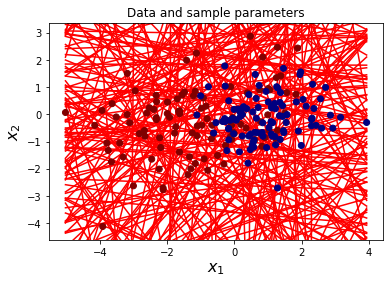

In [10]:
# w, b sampling
n_param_sample = 30000

w_param_var = 1
b_param_var = 30
ws = np.sqrt(w_param_var)*torch.randn([n_param_sample, dim], device=device)
bs = np.sqrt(w_param_var)*np.sqrt(b_param_var)*torch.randn([n_param_sample, 1], device=device)

max_plot_boundaries = 300
models_plot(ws[0:np.min([n_param_sample, max_plot_boundaries])].to('cpu'), \
            bs[0:np.min([n_param_sample, max_plot_boundaries])].to('cpu'), all_data.to('cpu'), ys.to('cpu'), \
            'Data and sample parameters')


$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$

We want to calculate
\begin{eqnarray}
P(y|\bx, Y, X) &=& \int P(y|\bx, \theta)p(\theta|Y,X) d\theta \\
&=& \int P(y|\bx, \theta) \frac{P(Y|X,\theta)p(\theta)}{P(Y|X)} d\theta \\
&=& \int P(y|\bx, \theta) \frac{p(\theta)\prod_{i = 1}^N P(y_i|\bx_i,\theta)}{\int p(\theta)\prod_{i = 1}^N P(y_i|\bx_i,\theta)d\theta} d\theta
\end{eqnarray}
with $\theta = \{\bw, b\}$, $y\in\{1,0\}$.

There are two ways of sampling: one way is to sample data from $p(\theta|Y,X)$ and the other is to sample from $p(\theta)$. 

When we sample data from $p(\theta|Y,X)$, we can use the following equation:
\begin{eqnarray}
P(y=1|\bx, Y,X) &=& \int P(y=1|\bx, \theta) p(\theta|Y,X) d\theta \\
&\approx& \frac{1}{M} \sum_{j = 1}^M \frac{1}{1 + \exp(-\bw_j^\top \bx + b_j)}
\end{eqnarray}
using $M$ number of samples from $\theta_j \sim p(\theta|Y,X)$.

When we sample from $p(\theta)$, we can consider using the following equation:
\begin{eqnarray}
P(y=1|\bx, Y,X) &=& \int P(y=1|\bx, \theta) p(\theta|Y,X) d\theta \\
&=& \int P(y=1|\bx, \theta) \frac{p(\theta)\prod_{i = 1}^N P(y_i|\bx_i,\theta)}{\int p(\theta)\prod_{i = 1}^N P(y_i|\bx_i,\theta)d\theta} d\theta \\
&\approx& \frac{1}{M} \sum_{j = 1}^M \frac{1}{1 + \exp(-\bw_j^\top \bx + b_j)}\cdot
\frac{1}{\frac{1}{M}\sum_{k = 1}^M \exp\left[\sum_{i = 1}^N \log(1 + \exp(-y_i(\bw_j^\top\bx_i - b_j))) - \log(1 + \exp(-y_i(\bw_k^\top\bx_i - b_k))) \right]}
\end{eqnarray}
using $M$ number of samples from $\theta_j \sim p(\theta)$. Here, we used the following equality:
\begin{eqnarray}
\Big( P(Y|X) = \Big)  \prod_{i = 1}^N P(y_i|\bx_i, \theta_j) &=& \prod_{i = 1}^N \frac{1}{1 + \exp(-y_i(\bw_j^\top\bx_i - b_j))} \\
&=& \exp\left[-\sum_{i = 1}^N \log\left(1 + \exp(-y_i(\bw_j^\top\bx_i - b_j))\right)\right].
\end{eqnarray}


In [11]:
# MC sample x datanum
a_vals = (torch.matmul(ws, all_data.T) - bs)*ys  # a = y(w'x-b)
log_1_exp_na = torch.log(1 + torch.exp(-a_vals))  # log(1 + exp(-a))

### Some parameters have large posteriors and others do not.

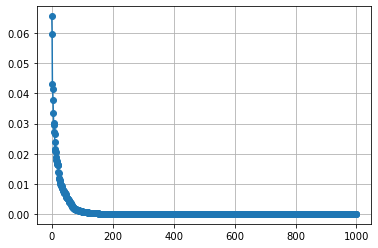

In [12]:
log_1_exp_na_datasum = torch.sum(log_1_exp_na, axis=1)
Posteriors = 1/torch.sum(torch.exp(log_1_exp_na_datasum.reshape([1,-1]) - \
                                   log_1_exp_na_datasum.reshape([-1,1])), axis=0)

# Posterior spectrum
plt.plot(torch.sort(Posteriors, descending=True).values[0:1000].to('cpu'), 'o-') # Some largest posteriors
plt.grid()

In [13]:
Posteriors[torch.argsort(Posteriors, descending=True)]

tensor([0.0656, 0.0598, 0.0432,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')

In [14]:
# Parameter Posteriors should be sum to one
torch.sum(Posteriors)

tensor(1., device='cuda:0')

### The parameter with maximum posterior

tensor([[0.9978],
        [0.9978],
        [0.9979],
        ...,
        [0.0085],
        [0.0087],
        [0.0088]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Text(0.5, 1.0, 'One sample max boundary - Approximation of MAP')

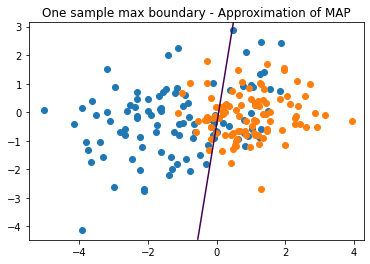

In [15]:
# one sample max parameter
max_idx = torch.argsort(Posteriors, descending=True)[0]

grid_resolution = 100
X = torch.arange(xmin, xmax, (xmax - xmin)/(grid_resolution - 0.01))
Y = torch.arange(ymin, ymax, (ymax - ymin)/(grid_resolution - 0.01))

grid_x, grid_y = torch.meshgrid(X, Y, indexing='ij')
scan_inputs = torch.cat([grid_x.reshape([-1,1]), grid_y.reshape([-1,1])], axis=1).to(device)

model = LogisticRegression(input_dim=dim, output_dim=1).to(device)
model.linear.weight.data = ws[max_idx].reshape([1,2])
model.linear.bias.data = -bs[max_idx]  # -b

discri_vals = model(scan_inputs)
print(discri_vals)
discri_vals = discri_vals.reshape([grid_resolution,grid_resolution]).T
plt.contour(X, Y, discri_vals.to('cpu').detach().numpy(), [0.5])
plt.scatter(data1.to('cpu')[:,0], data1.to('cpu')[:,1])
plt.scatter(data2.to('cpu')[:,0], data2.to('cpu')[:,1])
plt.title('One sample max boundary - Approximation of MAP')


tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0.9950, 0.9951, 0.9953,  ..., 0.0140, 0.0143, 0.0147], device='cuda:0',
       grad_fn=<AddBackward0>)


Text(0.5, 1.0, 'Combine the prediction of all parameter smaples')

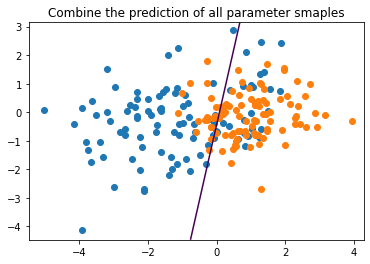

In [16]:
# Use all parameter samples

grid_resolution = 100
X = torch.arange(xmin, xmax, (xmax - xmin)/(grid_resolution - 0.01))
Y = torch.arange(ymin, ymax, (ymax - ymin)/(grid_resolution - 0.01))

# Produce grid data
grid_x, grid_y = torch.meshgrid(X, Y, indexing='ij')
scan_inputs = torch.cat([grid_x.reshape([-1,1]), grid_y.reshape([-1,1])], axis=1).to(device)

High_Posterior_idxes = torch.argsort(Posteriors, descending=True)
discri_vals = torch.zeros(grid_resolution*grid_resolution, device=device)
discri_vals_sq = torch.zeros(grid_resolution*grid_resolution, device=device)
print(discri_vals)
n_sum_sample = n_param_sample
model = LogisticRegression(input_dim=dim, output_dim=1)
for i_param_sample in High_Posterior_idxes[0:n_sum_sample]:
    # insert the parameter samples
    model.linear.weight.data = ws[i_param_sample].reshape([1,2])
    model.linear.bias.data = -bs[i_param_sample]  # -b

    # Weighted averaging of the class predictions (Sum of [class posterior]*[parameter posterior])
    discri_vals = discri_vals + model(scan_inputs).squeeze()*Posteriors[i_param_sample]
    discri_vals_sq = discri_vals_sq + model(scan_inputs).squeeze()**2*Posteriors[i_param_sample]

print(discri_vals)
discri_vals_plot = discri_vals.reshape([grid_resolution,grid_resolution]).T
plt.contour(X, Y, discri_vals_plot.to('cpu').detach().numpy(), [0.5])
plt.scatter(data1.to('cpu')[:,0], data1.to('cpu')[:,1])
plt.scatter(data2.to('cpu')[:,0], data2.to('cpu')[:,1])
plt.title('Combine the prediction of all parameter smaples')


#### Print the parameters with the highest posteriors

Take a look at the $\mathbf{w}$, $b$ parameters having the highest parameter posteriors, and their posterior values.

In [17]:
for i_param_sample in High_Posterior_idxes[0:3]:
    model = LogisticRegression(input_dim=dim, output_dim=1)
    model.linear.weight.data = ws[i_param_sample].reshape([1,2])
    model.linear.bias.data = -bs[i_param_sample]  # -b

    print(ws[i_param_sample], bs[i_param_sample], Posteriors[i_param_sample])

tensor([-1.2437,  0.1699], device='cuda:0') tensor([-0.0684], device='cuda:0') tensor(0.0656, device='cuda:0')
tensor([-1.4001,  0.3091], device='cuda:0') tensor([-0.0207], device='cuda:0') tensor(0.0598, device='cuda:0')
tensor([-1.3063,  0.2575], device='cuda:0') tensor([0.1072], device='cuda:0') tensor(0.0432, device='cuda:0')


### Contour plot of the variance of the prediction result and the Bayesian prediction result

This is the most 

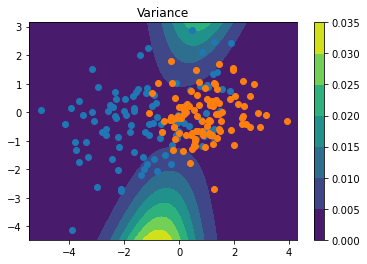

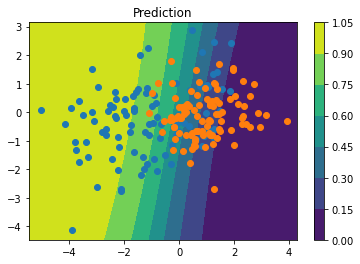

In [18]:
discri_var = discri_vals_sq - discri_vals**2
discri_var[torch.where(discri_var < 0)] = 0  # small negative values

discri_var_plot = discri_var.reshape([grid_resolution,grid_resolution]).T
discri_var_plot.shape

plt.contourf(X, Y, discri_var_plot.to('cpu').detach().numpy())
plt.colorbar()
# plt.clim(0, .2)
plt.scatter(data1.to('cpu')[:,0], data1.to('cpu')[:,1])
plt.scatter(data2.to('cpu')[:,0], data2.to('cpu')[:,1])
plt.title('Variance')
plt.show()


plt.contourf(X, Y, discri_vals_plot.to('cpu').detach().numpy())
plt.colorbar()
plt.scatter(data1.to('cpu')[:,0], data1.to('cpu')[:,1])
plt.scatter(data2.to('cpu')[:,0], data2.to('cpu')[:,1])
plt.title('Prediction')
plt.show()


### Compare with Frequentist's Logistic Regression result

We also have an alternative method of using logistic regression model. We can select a single parameter $\mathbf{w}$ and $b$ having the highest likelihood (=negative cross entropy). Compare the Bayesian result with that of Frequentist's approach.

Training Epochs: 100%|██████████| 20000/20000 [00:06<00:00, 2924.48it/s]


[-20.02822    -1.6037083] 21.981504


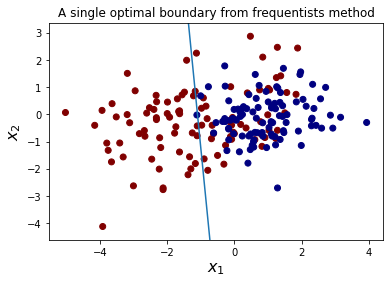

In [19]:
from tqdm import tqdm
# Frequentist optimization

losses = []
losses_test = []
Iterations = []
iter = 0
epochs = 20_000
learning_rate = 0.01

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = all_data
    labels = ys
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(x)
    loss = criterion(torch.squeeze(outputs), labels) # [200,1] -squeeze-> [200]
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    optimizer.step() # Updates weights and biases with the optimizer (SGD)

model_plot(model, all_data, labels,'A single optimal boundary from frequentist''s method')